In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/amritgos/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [3]:
df = YahooDownloader(start_date = '2011-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.SENSEX_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2011-01-03,289.799988,294.880005,286.019989,263.478271,107300.0,ASIANPAINT.BO,0
1,2011-01-03,271.450012,274.399994,268.429993,252.560455,1603895.0,AXISBANK.BO,0
2,2011-01-03,1559.949951,1564.949951,1470.000000,1108.281006,114420.0,BAJAJ-AUTO.BO,0
3,2011-01-03,456.908142,466.635864,453.223419,457.380585,5717.0,BAJAJFINSV.BO,0
4,2011-01-03,68.483635,68.488495,67.517021,64.054718,17478.0,BAJFINANCE.BO,0


In [5]:
df.shape

(73830, 8)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [7]:
# vix_df = pd.read_csv('datasets/IndiaVIX_data.csv')
# sentiment_df = pd.read_csv('datasets/Sentiment_Compiled.csv')

In [6]:
fe = FeatureEngineer(
                    use_technical_indicator=False,
                    use_turbulence=False,
                    use_vix=False,
                    # use_sentiment=True,
                    # sentiment_df=sentiment_df,
                    user_defined_feature = True)

processed = fe.preprocess_data(df)

Successfully added user defined features


In [7]:
processed.head()

,date,open,high,low,close,volume,tic,day,daily_return,return_lag_1,return_lag_2
3,2011-01-06,289.799988,289.799988,284.100006,260.857086,41860.0,ASIANPAINT.BO,3,-0.007549,0.002978,-0.009948
3,2011-01-06,264.410004,264.410004,260.010010,241.443100,603950.0,AXISBANK.BO,3,-0.002632,-0.029687,-0.044019
3,2011-01-06,1392.000000,1393.000000,1321.000000,996.826477,276347.0,BAJAJ-AUTO.BO,3,-0.036036,-0.071581,-0.100565
3,2011-01-06,459.855957,459.855957,444.281769,440.109985,5424.0,BAJAJFINSV.BO,3,-0.026609,-0.030666,-0.037760
3,2011-01-06,69.848549,69.848549,66.934143,62.775913,37942.0,BAJFINANCE.BO,3,-0.008339,-0.007697,-0.019964


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [8]:
train = data_split(processed, '2011-01-01','2019-01-01')
train

,date,open,high,low,close,volume,tic,day,daily_return,return_lag_1,return_lag_2
0,2011-01-06,289.799988,289.799988,284.100006,260.857086,41860.0,ASIANPAINT.BO,3,-0.007549,0.002978,-0.009948
0,2011-01-06,264.410004,264.410004,260.010010,241.443100,603950.0,AXISBANK.BO,3,-0.002632,-0.029687,-0.044019
0,2011-01-06,1392.000000,1393.000000,1321.000000,996.826477,276347.0,BAJAJ-AUTO.BO,3,-0.036036,-0.071581,-0.100565
0,2011-01-06,459.855957,459.855957,444.281769,440.109985,5424.0,BAJAJFINSV.BO,3,-0.026609,-0.030666,-0.037760
0,2011-01-06,69.848549,69.848549,66.934143,62.775913,37942.0,BAJFINANCE.BO,3,-0.008339,-0.007697,-0.019964
...,...,...,...,...,...,...,...,...,...,...,...
1965,2018-12-31,429.799988,432.299988,425.649994,419.215668,464991.0,SUNPHARMA.BO,0,0.014249,0.044506,0.040217
1965,2018-12-31,1901.000000,1910.150024,1887.000000,1782.842896,155314.0,TCS.BO,0,-0.001187,-0.008327,0.002143
1965,2018-12-31,716.000000,724.200012,715.400024,660.063171,50512.0,TECHM.BO,0,0.012354,0.018359,0.038077
1965,2018-12-31,928.000000,939.000000,920.700012,916.568787,163019.0,TITAN.BO,0,0.008076,0.047064,0.045887


In [9]:
sent = 0
tech = 0
user = 1
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + (tech*len(config.TECHNICAL_INDICATORS_LIST)+sent*len(config.SENTIMENT_INDICATORS_LIST)+user*len(config.USER_INDICATORS_LIST))*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 151


In [10]:
env_kwargs = {
    "hmax": 1000, 
    "initial_amount": 10000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    # "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "tech_indicator_list": [],
    # "sentiment_indicator_list": config.SENTIMENT_INDICATORS_LIST, 
    "sentiment_indicator_list": [],
    # "user_indicator_list": [],
    "user_indicator_list": config.USER_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "turbulence_threshold": None,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}

# print(config.TECHNICAL_INDICATORS_LIST,config.SENTIMENT_INDICATORS_LIST,config.USER_INDICATORS_LIST)

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [11]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [19]:
# initialize
agent = DRLAgent(env = env_train)
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.005}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=60000)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.005}
Using cpu device
Logging to tensorboard_log/a2c/a2c_5
------------------------------------
| time/                 |          |
|    fps                | 108      |
|    iterations         | 100      |
|    time_elapsed       | 4        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.005    |
|    n_updates          | 99       |
|    policy_loss        | -170     |
|    std                | 0.996    |
|    value_loss         | 38.8     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 114      |
|    iterations         | 200      |
|    time_elapsed       | 8        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -41.9    |
|    explained_variance | 1.19e-07 |


In [20]:
trade = data_split(processed,'2019-01-01', '2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [21]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

hit end!


In [22]:
df_daily_return.to_csv('df_returns_ddpg.csv')

In [23]:
df_actions.to_csv('df_actions_ddpg.csv')

In [24]:
from pyfolio import timeseries
s1 = get_daily_return(df_daily_return, value_col_name="account_value")
df_daily_return['daily_return'] = s1.values
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [25]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.277163
Cumulative returns     0.612252
Annual volatility      0.222783
Sharpe ratio           1.212176
Calmar ratio           0.915151
Stability              0.658602
Max drawdown          -0.302860
Omega ratio            1.285218
Sortino ratio          1.778890
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.057263
Daily value at risk   -0.026996
Alpha                  0.000000
Beta                   1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (490, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,23
,Backtest
Annual return,27.9%
Cumulative returns,61.364%
Annual volatility,22.301%
Sharpe ratio,1.22
Calmar ratio,0.92
Stability,0.66
Max drawdown,-30.286%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.29,2020-02-19,2020-03-23,2020-07-29,116
1,8.64,2019-06-03,2019-08-05,2019-09-20,80
2,5.73,2019-02-07,2019-02-19,2019-03-20,30
3,5.00,2020-09-18,2020-09-24,2020-10-08,15
4,4.26,2020-08-10,2020-08-31,2020-09-16,28


/home/amritgos/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.11%,-10.49%,10.84%


/home/amritgos/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


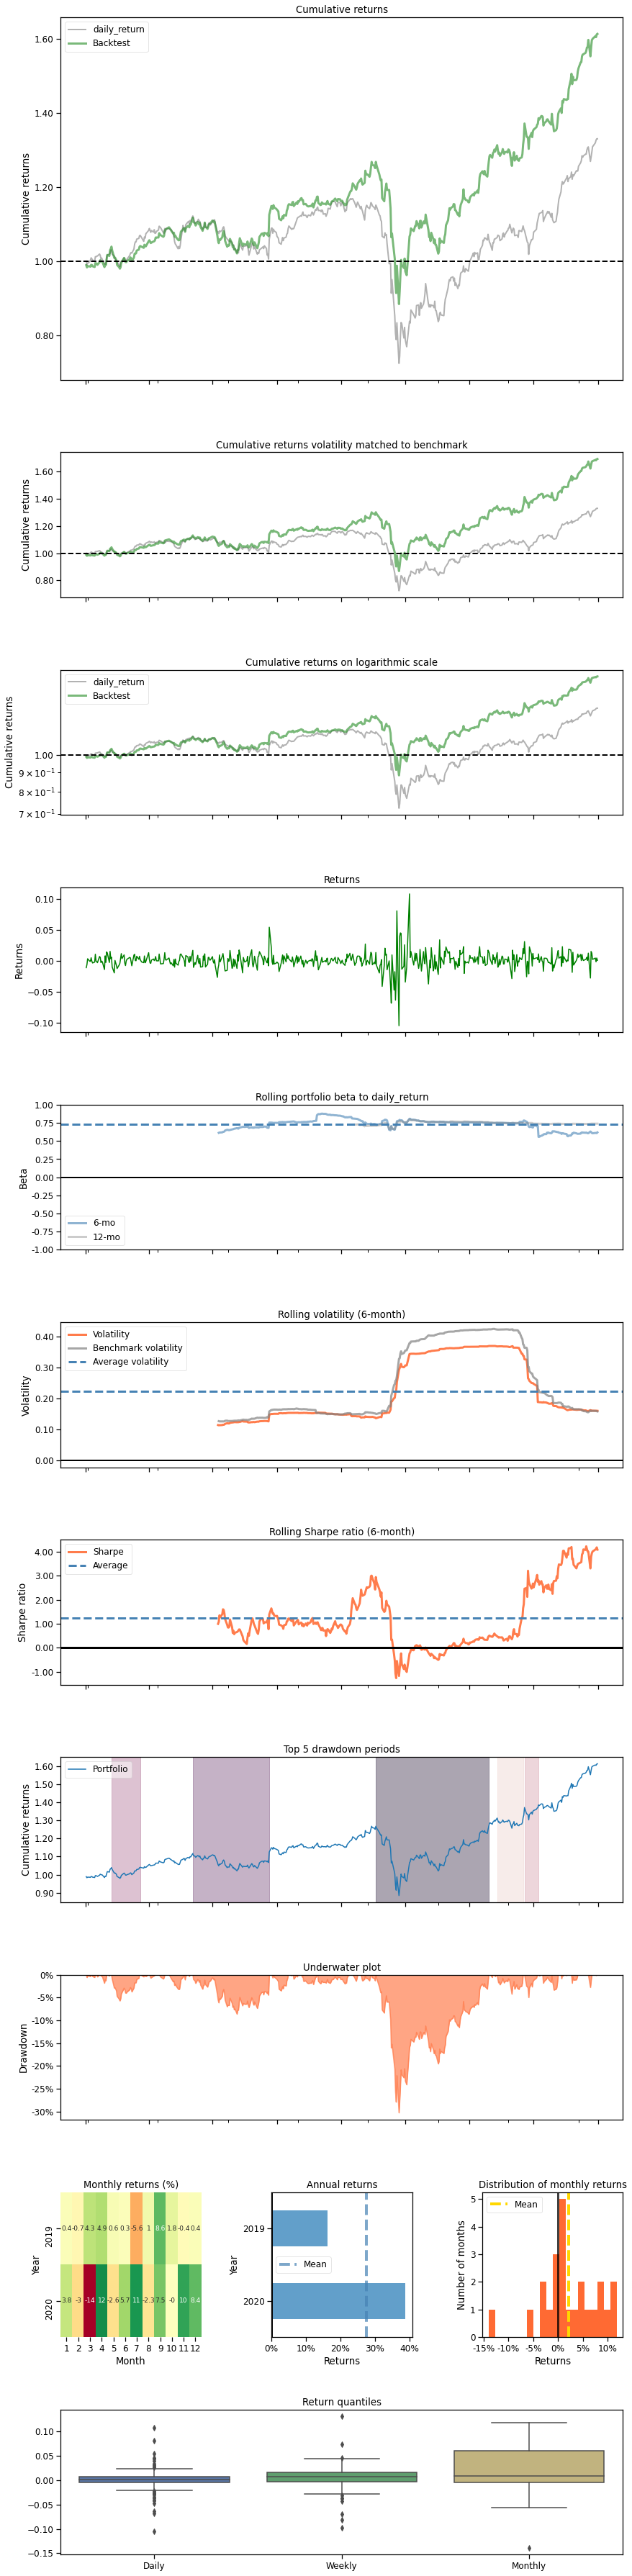

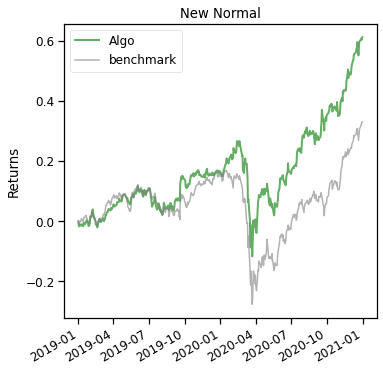

In [26]:
import pyfolio
import datetime as dt
%matplotlib inline

baseline_df = get_baseline(
        ticker='^BSESN', start='2019-01-01', end='2021-01-01')


baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)